<a href="https://colab.research.google.com/github/susumu2357/US-patent-analysis/blob/master/metric_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!mkdir -p ./data

!gsutil cp gs://mlstudy-phys/data/grants_for_3000+3000.df.gz ./data/ 
!gsutil cp gs://mlstudy-phys/data/testset_app_3000.df.gz ./data/
!gsutil cp gs://mlstudy-phys/data/training_app_3000.df.gz ./data/
!gsutil cp gs://mlstudy-phys/data/citations_info_3000+3000.df.gz ./data/ 

Copying gs://mlstudy-phys/data/grants_for_3000+3000.df.gz...
\ [1 files][129.4 MiB/129.4 MiB]                                                
Operation completed over 1 objects/129.4 MiB.                                    
Copying gs://mlstudy-phys/data/testset_app_3000.df.gz...
- [1 files][ 45.5 MiB/ 45.5 MiB]                                                
Operation completed over 1 objects/45.5 MiB.                                     
Copying gs://mlstudy-phys/data/training_app_3000.df.gz...
- [1 files][ 45.0 MiB/ 45.0 MiB]                                                
Operation completed over 1 objects/45.0 MiB.                                     
Copying gs://mlstudy-phys/data/citations_info_3000+3000.df.gz...
/ [1 files][506.5 KiB/506.5 KiB]                                                
Operation completed over 1 objects/506.5 KiB.                                    


In [0]:
import pandas as pd

grants = pd.read_pickle("./data/grants_for_3000+3000.df.gz")
test_app = pd.read_pickle("./data/testset_app_3000.df.gz")
train_app = pd.read_pickle("./data/training_app_3000.df.gz")
citations = pd.read_pickle("./data/citations_info_3000+3000.df.gz")

citations = citations[citations["action_type"] == 102]
cite_app = citations["app_id"]
cite_grant = citations ["parsed"]
cite_relation = pd.concat([cite_app, cite_grant], axis=1)

In [4]:
import gzip
import pickle

filename = "train_app_w2v_claim_background_IPC.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  train_app_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/train_app_w2v_claim_background_IPC.pkl.gz...
/ [1 files][  2.5 MiB/  2.5 MiB]                                                
Operation completed over 1 objects/2.5 MiB.                                      


In [5]:
filename = "test_app_w2v_claim_background_IPC.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  test_app_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/test_app_w2v_claim_background_IPC.pkl.gz...
/ [1 files][  2.5 MiB/  2.5 MiB]                                                
Operation completed over 1 objects/2.5 MiB.                                      


In [6]:
filename = "grant_w2v_claim_background_IPC.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  grant_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/grant_w2v_claim_background_IPC.pkl.gz...
/ [1 files][  5.3 MiB/  5.3 MiB]                                                
Operation completed over 1 objects/5.3 MiB.                                      


In [0]:
train_data = pd.merge(train_app, cite_relation, on='app_id')[["app_id", "parsed"]]
test_data = pd.merge(test_app, cite_relation, on='app_id')[["app_id", "parsed"]]

In [8]:
train_data.head()

,app_id,parsed
0,12130785,7212849
1,12652424,7814459
2,12652424,7814459
3,12214532,7652956
4,14204411,7439432


In [9]:
train_data.nunique()

app_id    3000
parsed    3234
dtype: int64

In [10]:
train_data.shape

(3961, 2)

In [0]:
train_data = train_data.drop_duplicates()

In [12]:
train_data.shape

(3268, 2)

In [13]:
train_data = train_data[~train_data["app_id"].duplicated()]
train_data.shape

(3000, 2)

In [14]:
test_data.shape

(3925, 2)

In [15]:
test_data = test_data.drop_duplicates()
test_data = test_data[~test_data["app_id"].duplicated()]
test_data.shape

(3000, 2)

In [0]:
train_data= train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [17]:
%%time

train_app_x = []
train_grant_x = []

for i in range(len(train_data)):
  app_id = train_data["app_id"][i]
  idx_app = train_app[train_app["app_id"] == app_id ].index.values[0]

  parsed = train_data["parsed"][i]
  idx_grant = grants[grants["parsed"] == parsed].index.values[0] 
  
  f1 = train_app_feature[idx_app]
  f2 = grant_feature[idx_grant]
  
  train_app_x.append(f1)
  train_grant_x.append(f2)  

CPU times: user 5.73 s, sys: 56 ms, total: 5.78 s
Wall time: 5.75 s


In [18]:
import numpy as np

train_app_x = np.array(train_app_x)
train_grant_x = np.array(train_grant_x)

train_app_x.shape, train_grant_x.shape

((3000, 208), (3000, 208))

In [19]:
%%time

test_app_x = []
test_grant_x = []

for i in range(len(test_data)):
  app_id = test_data["app_id"][i]
  idx_app = test_app[test_app["app_id"] == app_id ].index.values[0]

  parsed = test_data["parsed"][i]
  idx_grant = grants[grants["parsed"] == parsed].index.values[0]
  
  f1 = test_app_feature[idx_app] 
  f2 = grant_feature[idx_grant]
  
  test_app_x.append(f1)
  test_grant_x.append(f2)

CPU times: user 5.95 s, sys: 95.4 ms, total: 6.05 s
Wall time: 5.85 s


In [20]:
test_app_x = np.array(test_app_x)
test_grant_x = np.array(test_grant_x)

test_app_x.shape, test_grant_x.shape

((3000, 208), (3000, 208))

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.contrib.slim as slim

from tqdm import tqdm_notebook as tqdm

tf.enable_eager_execution()

In [0]:
import math

class Model(object):
    
  
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.W = tf.Variable( np.identity(self.input_shape))
        self.variables = [self.W]
    
    def frwrd_pass(self, X_app, X_grant, Y_train, m = 0.1, s = 1.0):
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)       
       
        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        W = tf.cast(self.W, tf.double)        
        
        cos_t = tf.reduce_sum(tf.matmul( normalized_X_app, W )*normalized_X_grant, axis=1)        
        
        cos_t_minus = tf.subtract(cos_t, m)
        s_cos_t_minus = tf.multiply(s, cos_t_minus)
        s_cos_t_minus = tf.cast(s_cos_t_minus, tf.double)
        
        cos_t_plus = tf.add(cos_t, m)
        s_cos_t_plus = tf.multiply(s, cos_t_plus)
        s_cos_t_plus = tf.cast(s_cos_t_plus, tf.double)            

        output = tf.where(Y_train, s_cos_t_minus, s_cos_t_plus)

        return output
      
    def predict(self, X_app, X_grant, s = 1.0):
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)
        
        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        W = tf.cast(self.W, tf.double)            
        
        cos_t = tf.reduce_sum(tf.matmul( normalized_X_app, W )*normalized_X_grant, axis=1)
        s_cos_t = tf.multiply(s, cos_t)
        s_cos_t = tf.cast(s_cos_t, tf.double)     
                
        return s_cos_t

In [0]:
train_y = np.identity(4)[0]
train_y

array([1., 0., 0., 0.])

In [0]:
import math

CURRICULUM = math.floor(math.log2(len(train_app_x)))
CURRICULUM

11

In [0]:
import math

def copy_app(one_app_f, length):
  
  for i in range(math.ceil(math.log2(length))):
    one_app_f = np.vstack((one_app_f,one_app_f))

  out = one_app_f[0:length]

  return out

In [0]:
test = copy_app(train_app_x[0], 2)
test.shape

(2, 208)

In [0]:
 train_grant_x[0:2].shape

(2, 208)

#2^1 ~ 2^11 sets

In [0]:
import math

loss_history = []

model = Model(input_shape=208)
BASE_SIZE = 2
CURRICULUM = math.floor(math.log2(len(train_app_x)))
BASE_EPOCHS = 2000

for i in tqdm(range(CURRICULUM)):
  print("curriculum:", i)
  length = int(BASE_SIZE**(i+1))
  epochs = max(math.ceil(BASE_EPOCHS/2**(i+1)),2)
  
  for _ in range(epochs):
    rnd_idx = np.random.permutation(len(train_app_x))
    train_app_x_rnd = train_app_x[rnd_idx,:]
    train_grant_x_rnd = train_grant_x[rnd_idx,:]
    train_y = np.identity(length)[0]

    for train_one_app in train_app_x_rnd[0:length]:
      with tf.GradientTape() as tape:
        logits = model.frwrd_pass(copy_app(train_one_app, length), train_grant_x_rnd[0:length], train_y, m=1/length)

        loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=train_y.astype(np.double))

        global_step = tf.Variable(0, trainable=False, name='global_step')
        learning_rate = tf.train.exponential_decay(0.01, global_step, EPOCHS, 0.96, staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        loss_history.append(loss.numpy())
        grads = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

      train_y = np.roll(train_y, 1)


#     logits_rec =  model.frwrd_pass(copy_app(train_app_x_rnd[0], length), train_grant_x_rnd[0:length], train_y)
#     pred = tf.nn.sigmoid(logits_rec).numpy()
#     prediction = [ 1 if elem >= 0.5 else 0 for elem in pred]
#     train_acc = tf.reduce_mean(tf.cast(tf.equal(prediction, train_y), tf.float32))
#     print(train_acc.numpy())

curriculum: 0
curriculum: 1
curriculum: 2
curriculum: 3
curriculum: 4
curriculum: 5
curriculum: 6
curriculum: 7
curriculum: 8
curriculum: 9
curriculum: 10


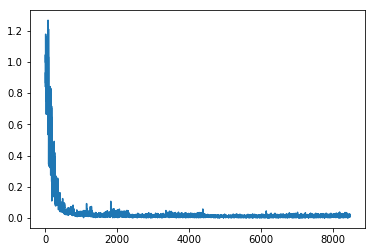

In [0]:
from matplotlib import pyplot as plt 
plt.plot([np.average(loss) for loss in loss_history] )

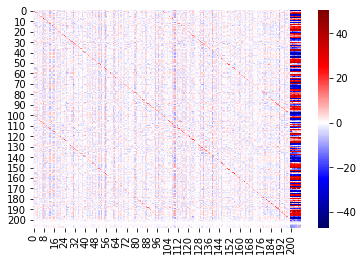

In [0]:
import seaborn as sns

sns.heatmap(model.W.numpy(), center=0, cmap='seismic')

In [0]:
%%time

predict_prob=[]
 
for i, one_app in enumerate(test_app_feature):
  list = model.predict(copy_app(one_app, len(grant_feature)), grant_feature).numpy()
  pred = tf.nn.sigmoid(list).numpy()
  predict_prob.append(pred)
  if i % 1000 ==0: print(i)

0
1000
2000
CPU times: user 1min 1s, sys: 3.24 s, total: 1min 4s
Wall time: 1min 18s


In [0]:
def test_label(app_id, grants, cite_relation):
  cited_parsed = cite_relation[cite_relation["app_id"] == app_id]["parsed"]
  return [ 1 if parsed == cited_parsed.values[0] else 0 for parsed in grants["parsed"] ]

In [0]:
%%time
import numpy as np

ranking = []
    
for app_idx, app_id in enumerate(test_app["app_id"]):
  label = pd.Series(test_label(app_id, grants, cite_relation))

  i, = np.where(label == 1)
  cited_index = i[0]
  rank = sorted(predict_prob[app_idx], reverse=True).index(predict_prob[app_idx][cited_index])
  ranking.append(rank)

CPU times: user 37.2 s, sys: 91.1 ms, total: 37.3 s
Wall time: 37.3 s


In [0]:
ranking_arr = np.array(ranking)

positive_counts = [sum(ranking_arr <= thrd) for thrd in range(len(grants))]

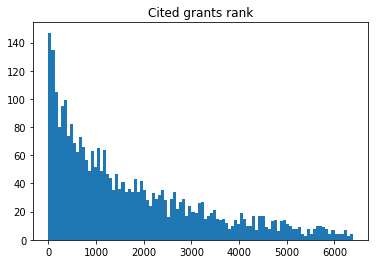

In [0]:
from matplotlib import pyplot as plt 

plt.hist(ranking, bins=100)
plt.title("Cited grants rank")
plt.show()

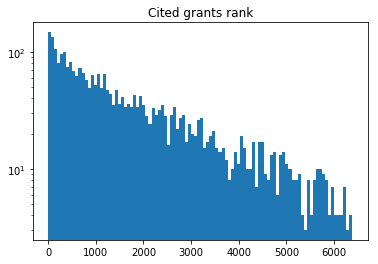

In [0]:
plt.hist(ranking, bins=100)
plt.yscale('log')
plt.title("Cited grants rank")
plt.show()

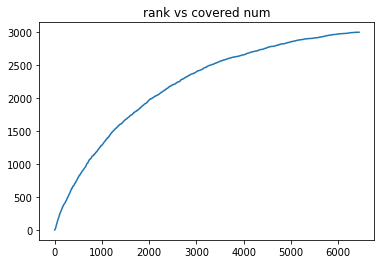

In [0]:
plt.plot(range(len(grants)), positive_counts)
plt.title("rank vs covered num")
plt.show()

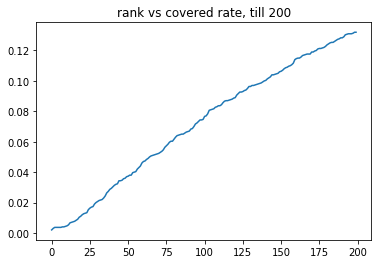

In [0]:
plt.plot(range(200), (np.array(positive_counts)/len(ranking))[0:200])
plt.title("rank vs covered rate, till 200")
plt.show()

In [0]:
print("w2v claim+background+IPC with metric learning top 10   : {:.3f}".format( (np.array(positive_counts)/len(ranking))[10]))
print("w2v claim+background+IPC with metric learning top 100  : {:.3f}".format( (np.array(positive_counts)/len(ranking))[100]))
print("w2v claim+background+IPC with metric learning top 200  : {:.3f}\n".format( (np.array(positive_counts)/len(ranking))[200]))

w2v claim+background+IPC with metric learning top 10   : 0.005
w2v claim+background+IPC with metric learning top 100  : 0.077
w2v claim+background+IPC with metric learning top 200  : 0.132



#pair training

In [0]:
import math

loss_history = []

model = Model(input_shape=208)
BATCH_SIZE = 250
EPOCHS = 1000

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_app_x))
  train_app_x_rnd = train_app_x[rnd_idx,:]
  train_grant_x_rnd = train_grant_x[rnd_idx,:]

  for idx in range(0, len(train_app_x), BATCH_SIZE):
    with tf.GradientTape() as tape:
      train_app_x_stack = [np.vstack((train, train)) for train in train_app_x_rnd[idx:idx+BATCH_SIZE]]
      train_app_x_stack = np.array(train_app_x_stack).reshape([2*BATCH_SIZE,208])
      
      train_grant_x_stack = [np.vstack((train, train)) for train in train_grant_x_rnd[idx:idx+BATCH_SIZE]]
      train_grant_x_stack = np.array(train_grant_x_stack).reshape([2*BATCH_SIZE,208])
      train_grant_x_stack = np.roll(train_grant_x_stack,1,axis=0)
      
      train_y_stack = [[0,1] for _ in train_app_x[idx:idx+BATCH_SIZE]]
      train_y_stack = np.array(train_y_stack).reshape([2*BATCH_SIZE])

      logits = model.frwrd_pass(train_app_x_stack, train_grant_x_stack, train_y_stack, m=0.2)

      loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=train_y_stack.astype(np.double))

      global_step = tf.Variable(0, trainable=False, name='global_step')
      learning_rate = tf.train.exponential_decay(0.01, global_step, 10*EPOCHS, 0.96, staircase=True)
      optimizer = tf.train.AdamOptimizer(learning_rate)
      loss_history.append(loss.numpy())
      grads = tape.gradient(loss, model.variables)
      optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

  train_app_x_stack = [np.vstack((train, train)) for train in train_app_x_rnd]
  train_app_x_stack = np.array(train_app_x_stack).reshape([2*len(train_app_x_rnd),208])

  train_grant_x_stack = [np.vstack((train, train)) for train in train_grant_x_rnd]
  train_grant_x_stack = np.array(train_grant_x_stack).reshape([2*len(train_grant_x_rnd),208])
  train_grant_x_stack = np.roll(train_grant_x_stack,1,axis=0)

  train_y_stack = [[0,1] for _ in train_app_x]
  train_y_stack = np.array(train_y_stack).reshape([2*len(train_app_x_rnd)])
  
  logits_rec = model.predict(train_app_x_stack, train_grant_x_stack)
  pred = tf.nn.sigmoid(logits_rec).numpy()
  prediction = [ 1 if elem >= 0.5 else 0 for elem in pred]
  train_acc = tf.reduce_mean(tf.cast(tf.equal(prediction, train_y_stack), tf.float32))
  print(train_acc.numpy())

0.67966664
0.755
0.78716666
0.7995
0.81116664
0.8153333
0.8261667
0.82566667
0.8348333
0.8491667
0.8491667
0.843
0.8548333
0.8551667
0.86333334
0.8625
0.8653333
0.86016667
0.86883336
0.86583334
0.863
0.8668333
0.8743333
0.875
0.87616664
0.87133336
0.881
0.87583333
0.87983334
0.88116664
0.88283336
0.8818333
0.8846667
0.8815
0.8846667
0.8835
0.8946667
0.8896667
0.8908333
0.8865
0.8936667
0.8985
0.89666665
0.89416665
0.896
0.8965
0.8905
0.89566666
0.8948333
0.90033334
0.896
0.89783335
0.9005
0.8976667
0.89883333
0.9038333
0.9035
0.90166664
0.90416664
0.8986667
0.89966667
0.9023333
0.905
0.90166664
0.91083336
0.9086667
0.9073333
0.9076667
0.90716666
0.9038333
0.90416664
0.906
0.908
0.9086667
0.9113333
0.9165
0.9145
0.90966666
0.9115
0.9203333
0.91283333
0.915
0.91333336
0.9173333
0.9113333
0.90833336
0.91116667
0.9176667
0.913
0.9155
0.9175
0.913
0.9138333
0.91983336
0.921
0.91866666
0.9173333
0.9176667
0.91533333
0.9215
0.914
0.92466664
0.9195
0.9151667
0.9213333
0.9241667
0.9163333
0.919

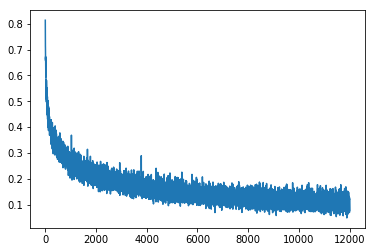

In [0]:
from matplotlib import pyplot as plt 
plt.plot([np.average(loss) for loss in loss_history] )

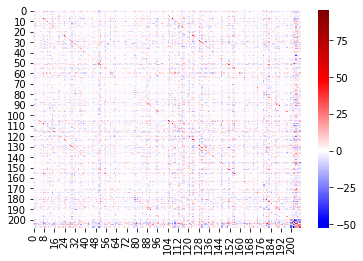

In [0]:
import seaborn as sns

sns.heatmap(model.W.numpy(), center=0, cmap='seismic')

In [0]:
train_app_x_stack = [np.vstack((train, train)) for train in train_app_x[0:3]]
train_app_x_stack = np.array(train_app_x_stack).reshape([6,208])
train_app_x_stack.shape

(6, 208)

In [0]:
train_grant_x_stack = [np.vstack((train, train)) for train in train_grant_x[0:3]]
train_grant_x_stack = np.array(train_grant_x_stack).reshape([6,208])
train_grant_x_stack = np.roll(train_grant_x_stack,1,axis=0)
train_grant_x_stack

array([[ 0.67822719, -0.07856964, -0.33874717, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.46088469,  0.45255002, -0.19697407, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.46088469,  0.45255002, -0.19697407, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.20201874, -0.17953689,  0.27081734, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20201874, -0.17953689,  0.27081734, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67822719, -0.07856964, -0.33874717, ...,  0.        ,
         0.        ,  0.        ]])

In [0]:
train_y_stack = [[0,1] for _ in train_app_x[0:3]]
train_y_stack = np.array(train_y_stack).reshape([6])
train_y_stack

array([0, 1, 0, 1, 0, 1])

In [0]:
def copy_app(one_app_f):
  
  length = math.ceil(math.log2(len(grant_feature)))

  for i in range(length):
    one_app_f = np.vstack((one_app_f,one_app_f))

  one_test_f = one_app_f[0:len(grant_feature)]

  return one_test_f

In [0]:
%%time

predict_prob=[]
 
for i, one_app in enumerate(test_app_feature):
  list = model.predict(copy_app(one_app), grant_feature).numpy()
  pred = tf.nn.sigmoid(list).numpy()
  predict_prob.append(pred)
  if i % 1000 ==0: print(i)

0
1000
2000
CPU times: user 1min 2s, sys: 2.93 s, total: 1min 4s
Wall time: 1min 19s


In [0]:
def test_label(app_id, grants, cite_relation):
  cited_parsed = cite_relation[cite_relation["app_id"] == app_id]["parsed"]
  return [ 1 if parsed == cited_parsed.values[0] else 0 for parsed in grants["parsed"] ]

In [0]:
%%time
import numpy as np

ranking = []
    
for app_idx, app_id in enumerate(test_app["app_id"]):
  label = pd.Series(test_label(app_id, grants, cite_relation))

  i, = np.where(label == 1)
  cited_index = i[0]
  rank = sorted(predict_prob[app_idx], reverse=True).index(predict_prob[app_idx][cited_index])
  ranking.append(rank)

CPU times: user 36 s, sys: 1.07 ms, total: 36 s
Wall time: 36 s


In [0]:
ranking_arr = np.array(ranking)

positive_counts = [sum(ranking_arr <= thrd) for thrd in range(len(grants))]

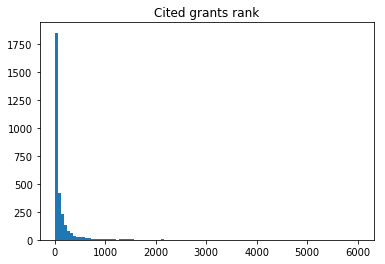

In [0]:
from matplotlib import pyplot as plt 

plt.hist(ranking, bins=100)
plt.title("Cited grants rank")
plt.show()

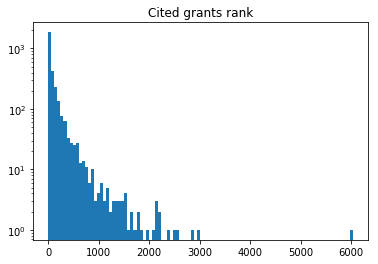

In [0]:
plt.hist(ranking, bins=100)
plt.yscale('log')
plt.title("Cited grants rank")
plt.show()

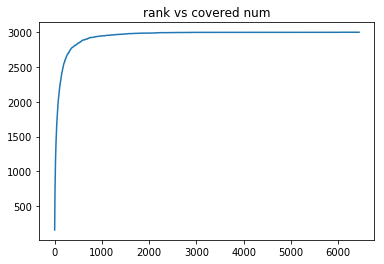

In [0]:
plt.plot(range(len(grants)), positive_counts)
plt.title("rank vs covered num")
plt.show()

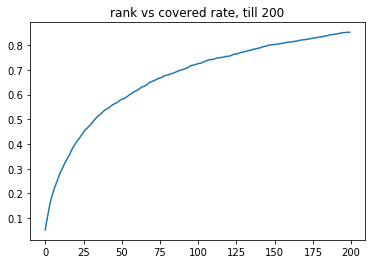

In [0]:
plt.plot(range(200), (np.array(positive_counts)/len(ranking))[0:200])
plt.title("rank vs covered rate, till 200")
plt.show()

In [0]:
print("w2v claim+background+IPC with metric learning top 10   : {:.3f}".format( (np.array(positive_counts)/len(ranking))[10]))
print("w2v claim+background+IPC with metric learning top 100  : {:.3f}".format( (np.array(positive_counts)/len(ranking))[100]))
print("w2v claim+background+IPC with metric learning top 200  : {:.3f}\n".format( (np.array(positive_counts)/len(ranking))[200]))

w2v claim+background+IPC with metric learning top 10   : 0.287
w2v claim+background+IPC with metric learning top 100  : 0.726
w2v claim+background+IPC with metric learning top 200  : 0.853



# pair training + det(W) penalty

In [0]:
import math

loss_history = []

model = Model(input_shape=208)
BATCH_SIZE = 250
EPOCHS = 200

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_app_x))
  train_app_x_rnd = train_app_x[rnd_idx,:]
  train_grant_x_rnd = train_grant_x[rnd_idx,:]

  for idx in range(0, len(train_app_x), BATCH_SIZE):
    with tf.GradientTape() as tape:
      train_app_x_stack = [np.vstack((train, train)) for train in train_app_x_rnd[idx:idx+BATCH_SIZE]]
      train_app_x_stack = np.array(train_app_x_stack).reshape([2*BATCH_SIZE,208])
      
      train_grant_x_stack = [np.vstack((train, train)) for train in train_grant_x_rnd[idx:idx+BATCH_SIZE]]
      train_grant_x_stack = np.array(train_grant_x_stack).reshape([2*BATCH_SIZE,208])
      train_grant_x_stack = np.roll(train_grant_x_stack,1,axis=0)
      
      train_y_stack = [[0,1] for _ in train_app_x[idx:idx+BATCH_SIZE]]
      train_y_stack = np.array(train_y_stack).reshape([2*BATCH_SIZE])

      logits = model.frwrd_pass(train_app_x_stack, train_grant_x_stack, train_y_stack, m=0.2)

      loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=train_y_stack.astype(np.double)) + 0.5*(tf.linalg.det(model.W))**2

      global_step = tf.Variable(0, trainable=False, name='global_step')
      learning_rate = tf.train.exponential_decay(0.01, global_step, 10*EPOCHS, 0.96, staircase=True)
      optimizer = tf.train.AdamOptimizer(learning_rate)
      loss_history.append(loss.numpy())
      grads = tape.gradient(loss, model.variables)
      optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

  train_app_x_stack = [np.vstack((train, train)) for train in train_app_x_rnd]
  train_app_x_stack = np.array(train_app_x_stack).reshape([2*len(train_app_x_rnd),208])

  train_grant_x_stack = [np.vstack((train, train)) for train in train_grant_x_rnd]
  train_grant_x_stack = np.array(train_grant_x_stack).reshape([2*len(train_grant_x_rnd),208])
  train_grant_x_stack = np.roll(train_grant_x_stack,1,axis=0)

  train_y_stack = [[0,1] for _ in train_app_x]
  train_y_stack = np.array(train_y_stack).reshape([2*len(train_app_x_rnd)])
  
  logits_rec = model.predict(train_app_x_stack, train_grant_x_stack)
  pred = tf.nn.sigmoid(logits_rec).numpy()
  prediction = [ 1 if elem >= 0.5 else 0 for elem in pred]
  train_acc = tf.reduce_mean(tf.cast(tf.equal(prediction, train_y_stack), tf.float32))
  print(train_acc.numpy())

0.667
0.7521667
0.7813333
0.8171667
0.8156667
0.81483334
0.8296667
0.8081667
0.8225
0.839
0.8425
0.8535
0.8696667
0.85216665
0.84583336
0.8475
0.87166667
0.8715
0.8806667
0.8745
0.87516665
0.87516665
0.8706667
0.877
0.8775
0.873
0.87633336
0.8695
0.8681667
0.87166667
0.8778333
0.8693333
0.86983335
0.8731667
0.87883335
0.8746667
0.8705
0.87416667
0.86866665
0.871
0.873
0.87333333
0.87166667
0.87016666
0.8775
0.877
0.879
0.87
0.8745
0.872
0.876
0.8705
0.8691667
0.87233335
0.8765
0.87333333
0.8728333
0.8705
0.8765
0.8693333
0.86733335
0.86733335
0.878
0.87166667
0.8663333
0.8678333
0.8718333
0.8638333
0.8645
0.8666667
0.86766666
0.8541667
0.87016666
0.867
0.86083335
0.86733335
0.8616667
0.86466664
0.86483335
0.86266667
0.86233336
0.8615
0.863
0.86116666
0.858
0.8588333
0.8668333
0.8603333
0.86583334
0.8803333
0.87116665
0.8771667
0.883
0.88133335
0.8706667
0.87833333
0.881
0.8815
0.87583333
0.8868333
0.8753333
0.86733335
0.87166667
0.86333334
0.85
0.8746667
0.8745
0.87916666
0.8775
0.8828

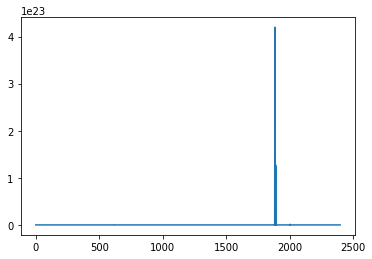

In [0]:
from matplotlib import pyplot as plt 
plt.plot([np.average(loss) for loss in loss_history] )

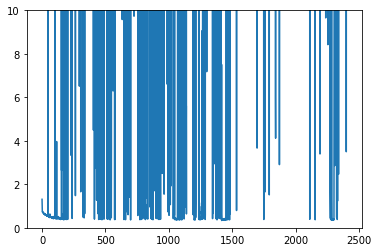

In [0]:
from matplotlib import pyplot as plt 
plt.ylim([0,10])
plt.plot([np.average(loss) for loss in loss_history] )

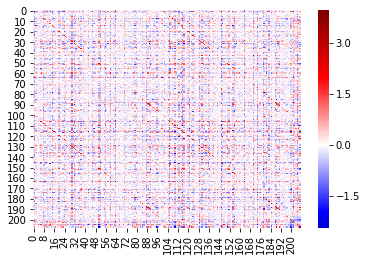

In [0]:
import seaborn as sns

sns.heatmap(model.W.numpy(), center=0, cmap='seismic')

In [0]:
tf.linalg.det(model.W).numpy()

671.4243427527712

#hardest pair training

In [0]:
import math

class Model_2(object):
    
  
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.W = tf.Variable( np.identity(self.input_shape))
        self.variables = [self.W]
    
    def frwrd_pass(self, X_app, X_grant, Y_train, m = 0.1, s = 1.0):
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)       
       
        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        W = tf.cast(self.W, tf.double)        
        
        cos_t = tf.reduce_sum(tf.matmul( normalized_X_app, W )*normalized_X_grant, axis=1)        
        
        cos_t_minus = tf.subtract(cos_t, m)
        s_cos_t_minus = tf.multiply(s, cos_t_minus)
        s_cos_t_minus = tf.cast(s_cos_t_minus, tf.double)
        
        # unbalance margin
        cos_t_plus = tf.add(cos_t, m*0.5)
        s_cos_t_plus = tf.multiply(s, cos_t_plus)
        s_cos_t_plus = tf.cast(s_cos_t_plus, tf.double)            

        output = tf.where(Y_train, s_cos_t_minus, s_cos_t_plus)

        return output
      
    def predict(self, X_app, X_grant, s = 1.0):
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)
        
        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        W = tf.cast(self.W, tf.double)            
        
        cos_t = tf.reduce_sum(tf.matmul( normalized_X_app, W )*normalized_X_grant, axis=1)
        s_cos_t = tf.multiply(s, cos_t)
        s_cos_t = tf.cast(s_cos_t, tf.double)     
                
        return s_cos_t

In [0]:
import math

def copy_app(one_app_f, length):
  
  for i in range(math.ceil(math.log2(length))):
    one_app_f = np.vstack((one_app_f,one_app_f))

  one_test_f = one_app_f[0:length]

  return one_test_f


def hardest_pair(one_app, grants):
  
  apps = copy_app(one_app, len(grants))  
  logits = model.predict(apps, grants)
  idx = np.where(logits.numpy() == logits.numpy().max())[0][0]
  
  return grants[idx]

In [0]:
import math

loss_history = []

model = Model_2(input_shape=208)
BATCH_SIZE = 500
EPOCHS = 50

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_app_x))
  train_app_x_rnd = train_app_x[rnd_idx,:]
  train_grant_x_rnd = train_grant_x[rnd_idx,:]

  for idx in range(0, len(train_app_x), BATCH_SIZE):
    with tf.GradientTape() as tape:
      train_app_x_stack = [np.vstack((app, app)) for app in train_app_x_rnd[idx:idx+BATCH_SIZE]]
      train_app_x_stack = np.array(train_app_x_stack).reshape([2*BATCH_SIZE,208])
      
      train_grant_x_stack = [np.vstack(( hardest_pair(app, np.roll(train_grant_x_rnd[idx:idx+BATCH_SIZE], -i, axis=0)[0:BATCH_SIZE-1]), grant)) for i, (app, grant) 
                             in enumerate(zip(train_app_x_rnd[idx:idx+BATCH_SIZE], train_grant_x_rnd[idx:idx+BATCH_SIZE]))]
      train_grant_x_stack = np.array(train_grant_x_stack).reshape([2*BATCH_SIZE,208])
      
      train_y_stack = [[0,1] for _ in train_app_x[idx:idx+BATCH_SIZE]]
      train_y_stack = np.array(train_y_stack).reshape([2*BATCH_SIZE])

      logits = model.frwrd_pass(train_app_x_stack, train_grant_x_stack, train_y_stack, m=0.4)

      loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=train_y_stack.astype(np.double))

      global_step = tf.Variable(0, trainable=False, name='global_step')
      learning_rate = tf.train.exponential_decay(0.0025, global_step, EPOCHS, 0.96, staircase=True)
      optimizer = tf.train.AdamOptimizer(learning_rate)
      loss_history.append(loss.numpy())
      grads = tape.gradient(loss, model.variables)
      optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

  train_app_x_stack = [np.vstack((app, app)) for app in train_app_x_rnd]
  train_app_x_stack = np.array(train_app_x_stack).reshape([2*len(train_app_x_rnd),208])

  train_grant_x_stack = [np.vstack((grant, grant)) for grant in train_grant_x_rnd]
  train_grant_x_stack = np.array(train_grant_x_stack).reshape([2*len(train_grant_x_rnd),208])
  train_grant_x_stack = np.roll(train_grant_x_stack,1,axis=0)

  train_y_stack = [[0,1] for _ in train_app_x]
  train_y_stack = np.array(train_y_stack).reshape([2*len(train_app_x_rnd)])
  
  logits_rec = model.predict(train_app_x_stack, train_grant_x_stack)
  pred = tf.nn.sigmoid(logits_rec).numpy()
  prediction = [ 1 if elem >= 0.5 else 0 for elem in pred]
  train_acc = tf.reduce_mean(tf.cast(tf.equal(prediction, train_y_stack), tf.float32))
  print(train_acc.numpy())

0.89883333
0.78616667
0.7835
0.75516665
0.807
0.769
0.8408333
0.87366664
0.88733333
0.8585
0.872
0.882
0.88383335
0.89
0.85733336
0.82666665
0.873
0.88283336
0.86183333
0.8845
0.8756667
0.772
0.73066664
0.7288333
0.705
0.7521667
0.8753333
0.86766666
0.892
0.87583333
0.8875
0.887
0.8845
0.8885
0.8975
0.88383335
0.87
0.88533336
0.90066665
0.87233335
0.8883333
0.89566666
0.8771667
0.8691667
0.8998333
0.8976667
0.8925
0.8935
0.8935
0.87


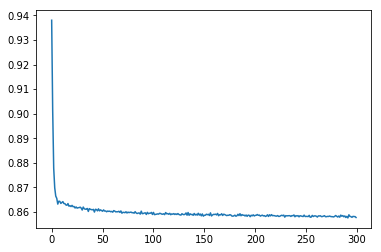

In [0]:
from matplotlib import pyplot as plt 
plt.plot([np.average(loss) for loss in loss_history] )

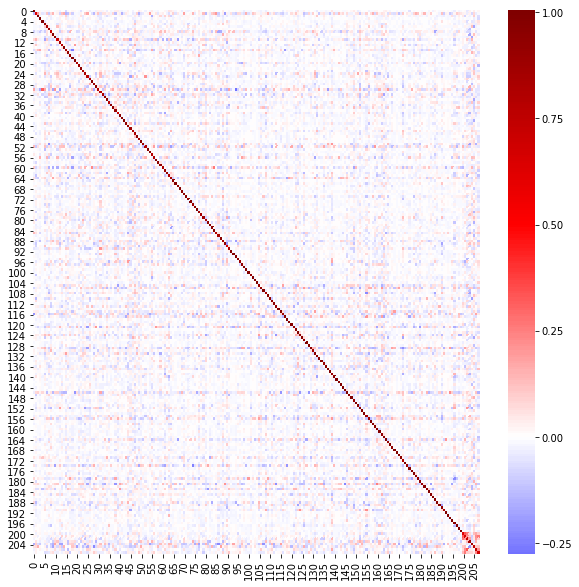

In [0]:
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(model.W.numpy(), center=0, cmap='seismic' )

In [0]:
np.trace(model.W.numpy()), np.linalg.det(model.W.numpy())

(191.73252914033503, 2.91109026140594e-13)

In [0]:
model = Model(input_shape=208)

logits = model.predict(copy_app(train_app_x[0], 9), train_grant_x[1:10])

np.where(logits.numpy() == logits.numpy().max())[0][0]

4

In [0]:
logits.numpy()

array([0.7225162 , 0.63685817, 0.65525895, 0.49003276, 0.80787373,
       0.70239489, 0.75179327, 0.79928459, 0.75525761])

In [0]:
model = Model(input_shape=208)

logits = model.predict(copy_app(train_app_x[0], 9), np.roll(train_grant_x[0:10], -1, axis=0)[0:9])

np.where(logits.numpy() == logits.numpy().max())[0][0]

4

In [0]:
logits.numpy()

array([0.7225162 , 0.63685817, 0.65525895, 0.49003276, 0.80787373,
       0.70239489, 0.75179327, 0.79928459, 0.75525761])

In [0]:
%%time

predict_prob=[]
 
for i, one_app in enumerate(test_app_feature):
  list = model.predict(copy_app(one_app, len(grant_feature)), grant_feature).numpy()
  pred = tf.nn.sigmoid(list).numpy()
  predict_prob.append(pred)
  if i % 1000 ==0: print(i)

0
1000
2000
CPU times: user 59.3 s, sys: 2.82 s, total: 1min 2s
Wall time: 1min 16s


In [0]:
%%time

def test_label(app_id, grants, cite_relation):
  cited_parsed = cite_relation[cite_relation["app_id"] == app_id]["parsed"]
  return [ 1 if parsed == cited_parsed.values[0] else 0 for parsed in grants["parsed"] ]

import numpy as np

ranking = []
    
for app_idx, app_id in enumerate(test_app["app_id"]):
  label = pd.Series(test_label(app_id, grants, cite_relation))

  i, = np.where(label == 1)
  cited_index = i[0]
  rank = sorted(predict_prob[app_idx], reverse=True).index(predict_prob[app_idx][cited_index])
  ranking.append(rank)

CPU times: user 34.9 s, sys: 0 ns, total: 34.9 s
Wall time: 34.9 s


In [0]:
ranking_arr = np.array(ranking)

positive_counts = [sum(ranking_arr <= thrd) for thrd in range(len(grants))]

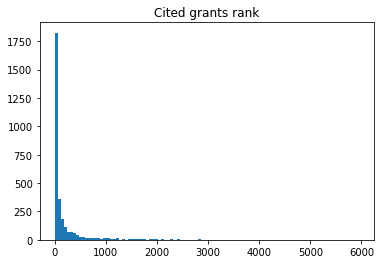

In [0]:
from matplotlib import pyplot as plt 

plt.hist(ranking, bins=100)
plt.title("Cited grants rank")
plt.show()

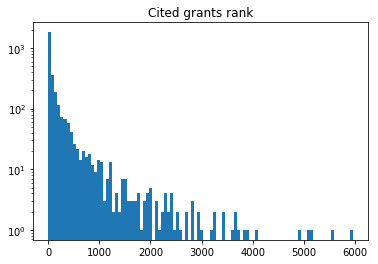

In [0]:
plt.hist(ranking, bins=100)
plt.yscale('log')
plt.title("Cited grants rank")
plt.show()

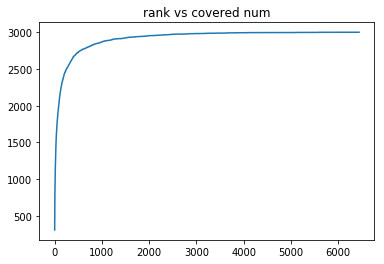

In [0]:
plt.plot(range(len(grants)), positive_counts)
plt.title("rank vs covered num")
plt.show()

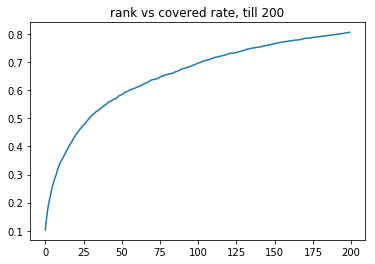

In [0]:
plt.plot(range(200), (np.array(positive_counts)/len(ranking))[0:200])
plt.title("rank vs covered rate, till 200")
plt.show()

In [0]:
print("w2v claim+background+IPC with metric learning top 10   : {:.3f}".format( (np.array(positive_counts)/len(ranking))[10]))
print("w2v claim+background+IPC with metric learning top 100  : {:.3f}".format( (np.array(positive_counts)/len(ranking))[100]))
print("w2v claim+background+IPC with metric learning top 200  : {:.3f}\n".format( (np.array(positive_counts)/len(ranking))[200]))

w2v claim+background+IPC with metric learning top 10   : 0.346
w2v claim+background+IPC with metric learning top 100  : 0.697
w2v claim+background+IPC with metric learning top 200  : 0.807



#picking up hard pair from top K

In [0]:
import math

class Model_2(object):
    
  
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.W = tf.Variable( np.identity(self.input_shape))
        self.variables = [self.W]
    
    def frwrd_pass(self, X_app, X_grant, Y_train, m = 0.1, s = 1.0):
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)       
       
        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        W = tf.cast(self.W, tf.double)        
        
        cos_t = tf.reduce_sum(tf.matmul( normalized_X_app, W )*normalized_X_grant, axis=1)        
        
        cos_t_minus = tf.subtract(cos_t, m)
        s_cos_t_minus = tf.multiply(s, cos_t_minus)
        s_cos_t_minus = tf.cast(s_cos_t_minus, tf.double)
        
        # unbalance margin
        cos_t_plus = tf.add(cos_t, m*0.5)
        s_cos_t_plus = tf.multiply(s, cos_t_plus)
        s_cos_t_plus = tf.cast(s_cos_t_plus, tf.double)            

        output = tf.where(Y_train, s_cos_t_minus, s_cos_t_plus)

        return output
      
    def predict(self, X_app, X_grant, s = 1.0):
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)
        
        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        W = tf.cast(self.W, tf.double)            
        
        cos_t = tf.reduce_sum(tf.matmul( normalized_X_app, W )*normalized_X_grant, axis=1)
        s_cos_t = tf.multiply(s, cos_t)
        s_cos_t = tf.cast(s_cos_t, tf.double)     
                
        return s_cos_t

In [0]:
import math

TOP_K = 10
SAMPLES = 1

def copy_app(one_app_f, length):
  
  for i in range(math.ceil(math.log2(length))):
    one_app_f = np.vstack((one_app_f,one_app_f))

  one_test_f = one_app_f[0:length]

  return one_test_f

# finding hard pair in every iterations. too slow.
def rand_hard_pair(one_app, grants):
  
  apps = copy_app(one_app, len(grants))  
  logits = model.predict(apps, grants).numpy()
  id_list = [np.where(logits == sorted_logit)[0][0] for sorted_logit in sorted(logits, reverse=True)] 
  id_sample = random.sample(id_list[0:TOP_K], SAMPLES)
  
  
  output = grants[id_sample[0]]
  
  for id in id_sample[1:]:
    output = np.vstack((output, grants[id]))
  
  return output

In [122]:
%%time

import math

loss_history = []

model = Model_2(input_shape=208)
BATCH_SIZE = 100
EPOCHS = 200

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_app_x))
  train_app_x_rnd = train_app_x[rnd_idx,:]
  train_grant_x_rnd = train_grant_x[rnd_idx,:]

  for idx in range(0, len(train_app_x), BATCH_SIZE):
    with tf.GradientTape() as tape:
      train_app_x_stack = [np.vstack((app, app)) for app in train_app_x_rnd[idx:idx+BATCH_SIZE]]
      train_app_x_stack = np.array(train_app_x_stack).reshape([2*BATCH_SIZE,208])
      
      train_grant_x_stack = [np.vstack(( rand_hard_pair(app, np.roll(train_grant_x_rnd[idx:idx+BATCH_SIZE], -i, axis=0)[0:BATCH_SIZE-1]), grant)) for i, (app, grant) 
                             in enumerate(zip(train_app_x_rnd[idx:idx+BATCH_SIZE], train_grant_x_rnd[idx:idx+BATCH_SIZE]))]
      train_grant_x_stack = np.array(train_grant_x_stack).reshape([2*BATCH_SIZE,208])
      
      train_y_stack = [[0,1] for _ in train_app_x[idx:idx+BATCH_SIZE]]
      train_y_stack = np.array(train_y_stack).reshape([2*BATCH_SIZE])

      logits = model.frwrd_pass(train_app_x_stack, train_grant_x_stack, train_y_stack, m=0.4)

      loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=train_y_stack.astype(np.double))

      global_step = tf.Variable(0, trainable=False, name='global_step')
      learning_rate = tf.train.exponential_decay(0.005, global_step, EPOCHS, 0.96, staircase=True)
      optimizer = tf.train.AdamOptimizer(learning_rate)
      loss_history.append(loss.numpy())
      grads = tape.gradient(loss, model.variables)
      optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

  train_app_x_stack = [np.vstack((app, app)) for app in train_app_x_rnd]
  train_app_x_stack = np.array(train_app_x_stack).reshape([2*len(train_app_x_rnd),208])

  train_grant_x_stack = [np.vstack((grant, grant)) for grant in train_grant_x_rnd]
  train_grant_x_stack = np.array(train_grant_x_stack).reshape([2*len(train_grant_x_rnd),208])
  train_grant_x_stack = np.roll(train_grant_x_stack,1,axis=0)

  train_y_stack = [[0,1] for _ in train_app_x]
  train_y_stack = np.array(train_y_stack).reshape([2*len(train_app_x_rnd)])
  
  logits_rec = model.predict(train_app_x_stack, train_grant_x_stack)
  pred = tf.nn.sigmoid(logits_rec).numpy()
  prediction = [ 1 if elem >= 0.5 else 0 for elem in pred]
  train_acc = tf.reduce_mean(tf.cast(tf.equal(prediction, train_y_stack), tf.float32))
  print(train_acc.numpy())

0.69
0.74266666
0.71316665
0.75733334
0.74
0.74233335
0.7305
0.773
0.7658333
0.77066666
0.7736667
0.7825
0.77433336
0.8053333
0.80016667
0.77816665
0.7981667
0.77816665
0.803
0.78466666
0.7865
0.7925
0.8165
0.8103333
0.7988333
0.80366665
0.8128333
0.82766664
0.824
0.8325
0.8013333
0.80366665
0.83283335
0.8305
0.814
0.835
0.80583334
0.83533335
0.80916667
0.83666664
0.8323333
0.83433336
0.8355
0.8323333
0.93116665
0.93016666
0.92833334
0.916
0.9213333
0.93016666
0.9148333
0.9306667
0.92766666
0.9295
0.92833334
0.9241667
0.9295
0.849
0.9275
0.9346667
0.929
0.921
0.829
0.84833336
0.8505
0.87516665
0.849
0.8513333
0.8638333
0.93516666
0.86366665
0.85566664
0.9346667
0.92983335
0.8551667
0.9215
0.8775
0.8566667
0.92266667
0.9325
0.93633336
0.8285
0.93233335
0.93666667
0.928
0.9393333
0.8656667
0.85966665
0.86483335
0.85966665
0.907
0.8728333
0.8771667
0.88383335
0.87083334
0.93083334
0.92766666
0.93
0.86466664
0.8666667
0.9393333
0.929
0.9356667
0.8725
0.9378333
0.8958333
0.853
0.8821667
0.8

#results of sampling 1 positive, 1 negative 

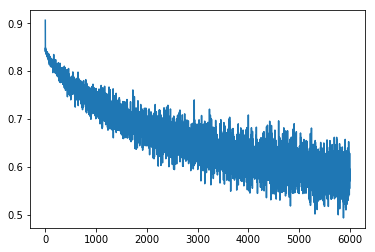

In [123]:
from matplotlib import pyplot as plt 
plt.plot([np.average(loss) for loss in loss_history] )

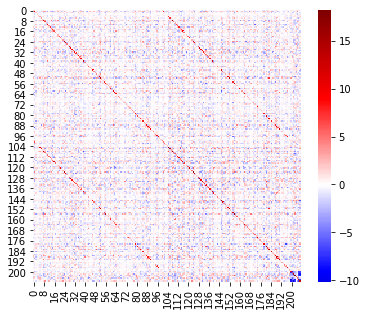

In [124]:
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(model.W.numpy(), center=0, cmap='seismic' )

In [125]:
np.trace(model.W.numpy()), np.linalg.det(model.W.numpy())

(1251.4637235994392, 1.152575794649618e+141)

In [126]:
%%time

predict_prob=[]
 
for i, one_app in enumerate(test_app_feature):
  list = model.predict(copy_app(one_app, len(grant_feature)), grant_feature).numpy()
  pred = tf.nn.sigmoid(list).numpy()
  predict_prob.append(pred)
  if i % 1000 ==0: print(i)

0
1000
2000
CPU times: user 54.8 s, sys: 4.75 s, total: 59.6 s
Wall time: 1min 1s


In [127]:
%%time

def test_label(app_id, grants, cite_relation):
  cited_parsed = cite_relation[cite_relation["app_id"] == app_id]["parsed"]
  return [ 1 if parsed == cited_parsed.values[0] else 0 for parsed in grants["parsed"] ]

import numpy as np

ranking = []
    
for app_idx, app_id in enumerate(test_app["app_id"]):
  label = pd.Series(test_label(app_id, grants, cite_relation))

  i, = np.where(label == 1)
  cited_index = i[0]
  rank = sorted(predict_prob[app_idx], reverse=True).index(predict_prob[app_idx][cited_index])
  ranking.append(rank)

CPU times: user 44.2 s, sys: 0 ns, total: 44.2 s
Wall time: 44.2 s


In [0]:
ranking_arr = np.array(ranking)

positive_counts = [sum(ranking_arr <= thrd) for thrd in range(len(grants))]

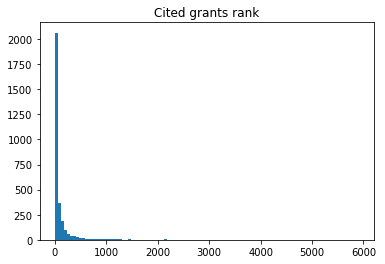

In [129]:
from matplotlib import pyplot as plt 

plt.hist(ranking, bins=100)
plt.title("Cited grants rank")
plt.show()

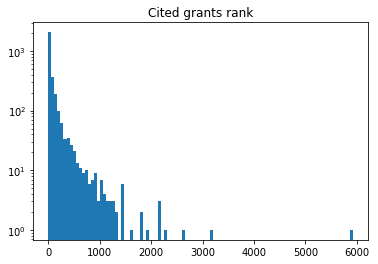

In [130]:
plt.hist(ranking, bins=100)
plt.yscale('log')
plt.title("Cited grants rank")
plt.show()

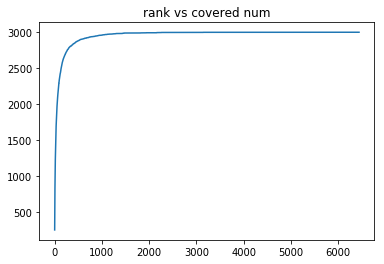

In [131]:
plt.plot(range(len(grants)), positive_counts)
plt.title("rank vs covered num")
plt.show()

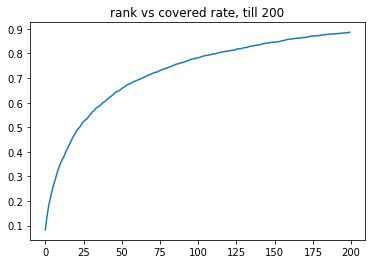

In [132]:
plt.plot(range(200), (np.array(positive_counts)/len(ranking))[0:200])
plt.title("rank vs covered rate, till 200")
plt.show()

In [133]:
print("w2v claim+background+IPC with metric learning top 10   : {:.3f}".format( (np.array(positive_counts)/len(ranking))[10]))
print("w2v claim+background+IPC with metric learning top 100  : {:.3f}".format( (np.array(positive_counts)/len(ranking))[100]))
print("w2v claim+background+IPC with metric learning top 200  : {:.3f}\n".format( (np.array(positive_counts)/len(ranking))[200]))

w2v claim+background+IPC with metric learning top 10   : 0.354
w2v claim+background+IPC with metric learning top 100  : 0.783
w2v claim+background+IPC with metric learning top 200  : 0.886



In [96]:
%%time

import math

loss_history = []

model = Model_2(input_shape=208)
BATCH_SIZE = 50
EPOCHS = 100

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_app_x))
  train_app_x_rnd = train_app_x[rnd_idx,:]
  train_grant_x_rnd = train_grant_x[rnd_idx,:]

  for idx in range(0, len(train_app_x), BATCH_SIZE):
    train_app_x_stack = [np.vstack((np.vstack((app, app)),app)) for app in train_app_x_rnd[idx:idx+BATCH_SIZE]]
    train_app_x_stack = np.array(train_app_x_stack).reshape([3*BATCH_SIZE,208])

    train_grant_x_stack = [np.vstack(( rand_hard_pair(app, np.roll(train_grant_x_rnd[idx:idx+BATCH_SIZE], -i, axis=0)[0:BATCH_SIZE-1]), grant)) for i, (app, grant) 
                           in enumerate(zip(train_app_x_rnd[idx:idx+BATCH_SIZE], train_grant_x_rnd[idx:idx+BATCH_SIZE]))]
    train_grant_x_stack = np.array(train_grant_x_stack).reshape([3*BATCH_SIZE,208])

    train_y_stack = [[0,0,1] for _ in train_app_x[idx:idx+BATCH_SIZE]]
    train_y_stack = np.array(train_y_stack).reshape([3*BATCH_SIZE])

    with tf.GradientTape() as tape:
      logits = model.frwrd_pass(train_app_x_stack, train_grant_x_stack, train_y_stack, m=0.4)

      loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=train_y_stack.astype(np.double))

      global_step = tf.Variable(0, trainable=False, name='global_step')
      learning_rate = tf.train.exponential_decay(0.005, global_step, EPOCHS, 0.96, staircase=True)
      optimizer = tf.train.AdamOptimizer(learning_rate)
      loss_history.append(loss.numpy())
      grads = tape.gradient(loss, model.variables)
      optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

  train_app_x_stack = [np.vstack((app, app)) for app in train_app_x_rnd]
  train_app_x_stack = np.array(train_app_x_stack).reshape([2*len(train_app_x_rnd),208])

  train_grant_x_stack = [np.vstack((grant, grant)) for grant in train_grant_x_rnd]
  train_grant_x_stack = np.array(train_grant_x_stack).reshape([2*len(train_grant_x_rnd),208])
  train_grant_x_stack = np.roll(train_grant_x_stack,1,axis=0)

  train_y_stack = [[0,1] for _ in train_app_x]
  train_y_stack = np.array(train_y_stack).reshape([2*len(train_app_x_rnd)])
  
  logits_rec = model.predict(train_app_x_stack, train_grant_x_stack)
  pred = tf.nn.sigmoid(logits_rec).numpy()
  prediction = [ 1 if elem >= 0.5 else 0 for elem in pred]
  train_acc = tf.reduce_mean(tf.cast(tf.equal(prediction, train_y_stack), tf.float32))
  print(train_acc.numpy())

0.541
0.568
0.539
0.5515
0.6635
0.5855
0.604
0.716
0.746
0.6638333
0.76233333
0.6855
0.75416666
0.75633335
0.75166667
0.789
0.6805
0.82
0.81366664
0.7173333
0.775
0.81133336
0.7456667
0.73983335
0.824
0.731
0.7415
0.7388333
0.72833335
0.8211667
0.82166666
0.7798333
0.80233335
0.78
0.7661667
0.743
0.78466666
0.74616665
0.8211667
0.76266664
0.7816667
0.79683334
0.8295
0.8068333
0.8398333
0.79966664
0.8425
0.82566667
0.81333333
0.8438333
0.79866666
0.7805
0.8566667
0.86016667
0.82233334
0.863
0.81916666
0.7985
0.8006667
0.8258333
0.8235
0.832
0.8545
0.8678333
0.838
0.89
0.914
0.8665
0.79116666
0.815
0.80333334
0.82516664
0.843
0.89416665
0.86466664
0.86366665
0.88
0.851
0.8056667
0.82283336
0.85983336
0.8413333
0.9036667
0.87
0.8355
0.853
0.8465
0.90033334
0.89566666
0.8578333
0.84933335
0.9033333
0.8385
0.83816665
0.8835
0.8498333
0.85116667
0.895
0.82266665
0.8168333
CPU times: user 21min 21s, sys: 2min 8s, total: 23min 30s
Wall time: 18min 37s


#results of sampling 1 positive, 2 negatives 

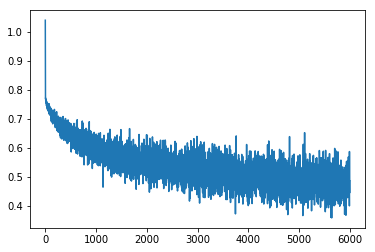

In [97]:
from matplotlib import pyplot as plt 
plt.plot([np.average(loss) for loss in loss_history] )

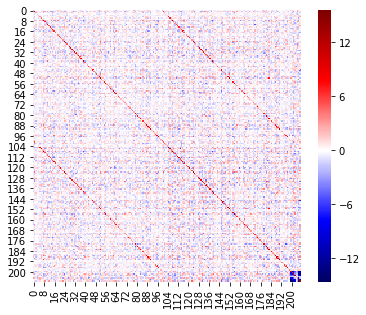

In [98]:
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(model.W.numpy(), center=0, cmap='seismic' )

In [86]:
np.trace(model.W.numpy()), np.linalg.det(model.W.numpy())

(555.11737492924, -1.718893276862828e+70)

In [99]:
%%time

predict_prob=[]
 
for i, one_app in enumerate(test_app_feature):
  list = model.predict(copy_app(one_app, len(grant_feature)), grant_feature).numpy()
  pred = tf.nn.sigmoid(list).numpy()
  predict_prob.append(pred)
  if i % 1000 ==0: print(i)

0
1000
2000
CPU times: user 53.8 s, sys: 5.14 s, total: 58.9 s
Wall time: 1min


In [100]:
%%time

def test_label(app_id, grants, cite_relation):
  cited_parsed = cite_relation[cite_relation["app_id"] == app_id]["parsed"]
  return [ 1 if parsed == cited_parsed.values[0] else 0 for parsed in grants["parsed"] ]

import numpy as np

ranking = []
    
for app_idx, app_id in enumerate(test_app["app_id"]):
  label = pd.Series(test_label(app_id, grants, cite_relation))

  i, = np.where(label == 1)
  cited_index = i[0]
  rank = sorted(predict_prob[app_idx], reverse=True).index(predict_prob[app_idx][cited_index])
  ranking.append(rank)

CPU times: user 44 s, sys: 0 ns, total: 44 s
Wall time: 44 s


In [0]:
ranking_arr = np.array(ranking)

positive_counts = [sum(ranking_arr <= thrd) for thrd in range(len(grants))]

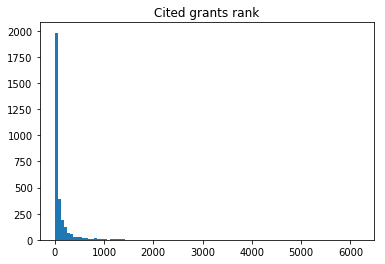

In [102]:
from matplotlib import pyplot as plt 

plt.hist(ranking, bins=100)
plt.title("Cited grants rank")
plt.show()

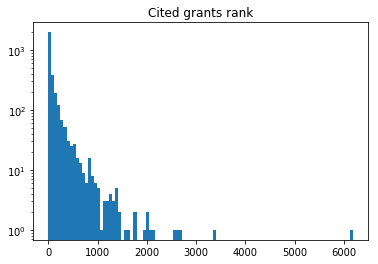

In [103]:
plt.hist(ranking, bins=100)
plt.yscale('log')
plt.title("Cited grants rank")
plt.show()

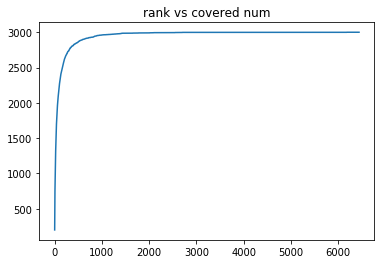

In [104]:
plt.plot(range(len(grants)), positive_counts)
plt.title("rank vs covered num")
plt.show()

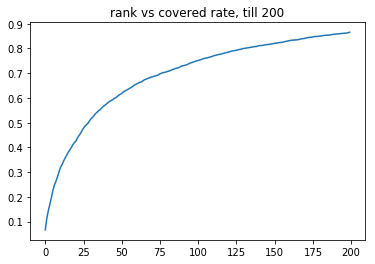

In [105]:
plt.plot(range(200), (np.array(positive_counts)/len(ranking))[0:200])
plt.title("rank vs covered rate, till 200")
plt.show()

In [106]:
print("w2v claim+background+IPC with metric learning top 10   : {:.3f}".format( (np.array(positive_counts)/len(ranking))[10]))
print("w2v claim+background+IPC with metric learning top 100  : {:.3f}".format( (np.array(positive_counts)/len(ranking))[100]))
print("w2v claim+background+IPC with metric learning top 200  : {:.3f}\n".format( (np.array(positive_counts)/len(ranking))[200]))

w2v claim+background+IPC with metric learning top 10   : 0.320
w2v claim+background+IPC with metric learning top 100  : 0.751
w2v claim+background+IPC with metric learning top 200  : 0.867

